In [484]:
%matplotlib inline
%matplotlib notebook
import csv
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from random import randint
import motion_tracking2 as motion_tracking
from scipy.optimize import linear_sum_assignment
import copy
import time
import math
import traj_dist.distance as tdist
import itertools

In [485]:
FONT = cv2.FONT_HERSHEY_SIMPLEX
EPS = 1e-3 # float underflow tolerance

# Image Collection

In [486]:
sequence_path = "sequence\\"
background_img = "background.png"

# path = base path
# folders = folders within path that contain images
# Returns a list of strings of the relative path names for every image in path/ within every folder in folders
def get_files(path):
    file_list = list()
    for (dir_path, dir_names, file_names) in os.walk(path):
        file_list += [os.path.join(dir_path, file) for file in file_names]
    return file_list

In [487]:
images = get_files(sequence_path)
bg_img = cv2.imread(background_img)
bg_img_gray = cv2.cvtColor(bg_img, cv2.COLOR_BGR2GRAY)

# Background Subtraction

In [488]:
k_open = np.ones((3,3),np.uint8)
k_close = np.ones((15,15), np.uint8)
k_erode = np.ones((5,5),np.uint8)
k_dilate = np.ones((5,5),np.uint8)

def bg_subtract(img): # uses globals
    #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    subtract_1 = cv2.absdiff(bg_img, img)
    subtract = np.max(subtract_1, axis=2)
    
    ret, thresholded = cv2.threshold(subtract, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    morphed = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, k_open)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_ERODE, k_erode)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_DILATE, k_dilate)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_CLOSE, k_close)
    return morphed

# Pedestrian Detection

# YOLO Detector Code

In [489]:
class YoloDetector:
    def __init__(self, frame_width, frame_height):
        self.width = frame_width
        self.height = frame_height
        self.net = cv2.dnn.readNet('yolov3.weights','yolov3.cfg')
        with open("coco.names", "r") as f:
            self.classes = [line.strip() for line in f.readlines()]

        layer_names = self.net.getLayerNames()
        self.output_layers = [layer_names[i[0] - 1] for i in self.net.getUnconnectedOutLayers()]
        
        #self.colors = np.random.uniform(0, 255, size=(len(classes), 3))
        #self.font = cv2.FONT_HERSHEY_PLAIN
        
    def get_detection(self, img):
        blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
        self.net.setInput(blob)
        outs = self.net.forward(self.output_layers)

        class_ids = []
        confidences = []
        boxes = []
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    # Object detected
                    center_x = int(detection[0] * self.width)
                    center_y = int(detection[1] * self.height)
                    w = int(detection[2] * self.width)
                    h = int(detection[3] * self.height)
                    # Rectangle coordinates
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    
                    # Retain only pedestrians
                    label = str(self.classes[class_id])
                    if label == 'person':
                        boxes.append([x, y, w, h])
                        confidences.append(float(confidence))
                        class_ids.append(class_id)
        
        # Remove overlapping duplicate boxes
        best_boxes = []
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
        for index_array in indexes:
            best_boxes.append(boxes[index_array[0]])
        return best_boxes
        #return boxes, indexes, class_ids


def draw_rectangle(img, bbox, label, font, color):
    cur_x, cur_y, cur_w, cur_h = bbox
    img = cv2.rectangle(img, (cur_x, cur_y), (cur_x + cur_w, cur_y + cur_h), color, 2)
    img = cv2.putText(img, str(label), (cur_x+int(cur_w/2),cur_y-2), font, 0.5, color,2)
    return img

def draw_rectangles(boxes, img, color):
    for i in range(len(boxes)):
        x, y, w, h = boxes[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        #cv2.putText(img, label, (x, y + 30), font, 3, (255,0,0), 3)
    return img

def centroid(bbox):
    x,y,w,h = bbox
    return (x + int(w/2), y + int(h/2))

def centroid_list(bboxes):
    centroids = []
    for i in range(len(bboxes)):
        x,y,w,h = bboxes[i]
        centroids.append((x + int(w/2), y + int(h/2)))
    return centroids

# Pedestrian Tracking

In [490]:
def calc_histogram_feature(img, mask, bbox, is_norm): # color histogram
    # if no bounded img is grabbed; bbox is no longer valid; insert black image
    if motion_tracking.invalid_bbox(img,bbox):
        bounded_img = np.zeros((21,21,3), dtype=np.uint8)
        bounded_mask = np.zeros((21,21), dtype=np.uint8)
        thres1, thres2 = 7, 14
    else:
        x,y,w,h = bbox[:4]
        thres1, thres2 = int(h/3), int(h*2/3)
        bounded_img = img[y:y+h, x:x+w]
        bounded_mask = mask[y:y+h, x:x+w]
    
    hsv_img = cv2.cvtColor(bounded_img,cv2.COLOR_BGR2HSV)
    if type(hsv_img) == type(None): # debug only
        print(bounded_img.size, bbox, motion_tracking.clip_ords(img,bbox))
    hsv_parts = [ hsv_img[:,:thres1], hsv_img[:,thres1:thres2], hsv_img[:,thres2:] ]
    mask_parts = [ bounded_mask[:,:thres1], bounded_mask[:,thres1:thres2], bounded_mask[:,thres2:] ]
    hist_parts = []
    hist_contribution = np.zeros(len(hsv_parts))
    
    for i in range(len(hsv_parts)):
        particle_subhist = cv2.calcHist([hsv_parts[i]], [0, 1], mask_parts[i], [180, 256], [0, 180, 0, 256])
        particle_subhist_sum = particle_subhist.sum()
        if is_norm and particle_subhist_sum > 0: # normalise by number of counted occurrences
            particle_subhist /= particle_subhist_sum
        hist_parts.append(particle_subhist)
        hist_contribution[i] = particle_subhist_sum
    return hist_parts, hist_contribution
    # histogram(s) of img split as three columns; num masked entries in each subhist

class Person:
    # prediction params (constant velocity)
    VELOCITY_WINDOW_FRAMES = 10
    # tracking threshold params
    INNER_BORDER_RECT = (398, 177, 67, 187) # (x,y,w,h) ROI rect between inner (lamppost) and middle regions
    BORDER_PX = 20 # edge between middle and outer regions
    CONSEC_TRACKED_FRAMES_THRESHOLD_INNER = 50
    CONSEC_TRACKED_FRAMES_THRESHOLD_MIDDLE = 10
    CONSEC_TRACKED_FRAMES_THRESHOLD_OUTER = 5
    SUDDEN_FP_THRES = 10 # frames
    
    def __init__(self, bbox, frame_width, frame_height, num_particles, person_id, img, mask, hc):
        x,y,w,h,__,__ = bbox
        self.person_id = person_id
        self.bbox_history = [] # item: (x,y,w,h,frameID,isTracked)
        self.consec_frames_tracked = 0
        self.velocity_history = [] # item: (vx,vy,std,frameID)
        
        #self.tracker = motion_tracking.ParticleFilter(frame_width, frame_height, num_particles)
        self.tracker = motion_tracking.ParticleFilter(w, h, num_particles, x, y)
        self.last_prediction = None # just: (x,y,w,h)
        self.prev_normhist, self.prev_normhist_nentries = calc_histogram_feature(img, mask, bbox, True)
        self.update_tracker(bbox, img, mask, hc, None, None, False)
    
    def get_latest_ords(self):
        return self.bbox_history[-1]

    def predict_tracker(self, vx, vy, std, img, frame_id):
        self.velocity_history.append((vx,vy,std,frame_id))
        max_index = len(self.velocity_history)-1
        avg_vx, avg_vy, count = 0, 0, 0
        for i in range(max_index, max(-1,max_index-self.VELOCITY_WINDOW_FRAMES), -1):
            avg_vx += self.velocity_history[i][0]
            avg_vy += self.velocity_history[i][1]
            count += 1
        avg_vx /= count
        avg_vy /= count
        #print(f'{frame_id}: p{self.person_id}, avg_vx={round(avg_vx,3)}, avg_vy={round(avg_vy,3)}')
        self.tracker.predict(avg_vx,avg_vy,std) # shift the (unweighted) particles
        ux, uy, __, __ = self.tracker.estimate() # weighted avg of particles
        x,y,w,h,frame_id, is_tracked = self.get_latest_ords()
        predicted_bbox = motion_tracking.clip_ords(img, (ux, uy, w, h))
        self.last_prediction = predicted_bbox
        return predicted_bbox
    
    def update_tracker(self,bbox, img,mask,hc, std_m,alpha, is_hist_method):
        # add to bbox path history and miscell counters
        x,y,w,h = motion_tracking.clip_ords(img, bbox)
        __,__,__,__,frame_id, is_tracked = bbox
        bbox = (x,y,w,h,frame_id,is_tracked) # clipped
        self.bbox_history.append(bbox)
        if is_tracked:
            self.consec_frames_tracked += 1
        else:
            self.consec_frames_tracked = 0
        
        # interpolate with new histogram (of identical bins)
        cur_hist, cur_normhist_nentries = calc_histogram_feature(img, mask, bbox, True)
        for i in range(len(cur_hist)):
            self.prev_normhist[i] = (1-hc) * cur_hist[i] + hc * self.prev_normhist[i]
            self.prev_normhist[i][ self.prev_normhist[i] < EPS ] = 0
            self.prev_normhist_nentries[i] = (1-hc) * cur_normhist_nentries[i] + hc * self.prev_normhist_nentries[i]
        
        # (computes the weights for the particles; does not do other book-keeping/side-effects)
        if is_hist_method:
            # update weights (from histogram)
            wd = self.tracker.get_particle_detection_weights(x,y,std_m)
            wc = self.tracker.get_color_appearance_weights(img,mask,w,h, self.prev_normhist,
                                                           self.prev_normhist_nentries, 
                                                           calc_histogram_feature)
            self.tracker.update_dual_weights(wd, wc, alpha)
        else:
            self.tracker.update(x,y) # update weights (from Euclidean)
        self.tracker.resample(method='residual') # new set of particles
    
    def is_stale_tracker(self, img): # True --> stale
        cx, cy, cw, ch, __, is_tracked = self.get_latest_ords()
        cbbox = (cx,cy,cw,ch)
        img_h, img_w = img.shape[:2]
        # check if tracker is currently associated to a detection
        if not is_tracked:
            return False
        # check if tracker bounds are invalid
        if motion_tracking.invalid_bbox(img, cbbox):
            return True
        
        # check if last detection occurred a while ago
        # (threshold will be lower near edge of image)
        consec_tracked_frames_threshold = self.CONSEC_TRACKED_FRAMES_THRESHOLD_MIDDLE
        # ** inner-middle boundary (basically hardcoded)
        pole_x0, pole_y0, pole_w, pole_h = self.INNER_BORDER_RECT
        pole_x1, pole_y1 = pole_x0+pole_w, pole_y0+pole_h
        if not ((cx+cw) < pole_x0 or (cy+ch) < pole_y0 or cx > pole_x1 or cy > pole_y1):
            # not completely outside the inner boundary, so qualify as being inside
            consec_tracked_frames_threshold = self.CONSEC_TRACKED_FRAMES_THRESHOLD_INNER
        else: # (elif)
            # ** middle-outer boundary
            by0,by1 = self.BORDER_PX, img_h-self.BORDER_PX
            bx0,bx1 = self.BORDER_PX, img_w-self.BORDER_PX
            if cx < bx0 or cy < by0 or (cx+cw) > bx1 or (cy+ch) > by1:
                # bbox is on the edge of the image
                consec_tracked_frames_threshold = self.CONSEC_TRACKED_FRAMES_THRESHOLD_OUTER
            
        if self.consec_frames_tracked >= consec_tracked_frames_threshold:
            return True
        
        # check if tracker was newly created on a false positive that has now disappeared
        if len(self.bbox_history) <= self.SUDDEN_FP_THRES: 
            is_tracked_list = [b[-1] for i,b in enumerate(self.bbox_history) if i < self.SUDDEN_FP_THRES]
            if is_tracked_list.count(True) > int(self.SUDDEN_FP_THRES/2):
                return True # short early path, with majority of bboxes being tracked
        return False # tracker not stale
    
    def __str__(self):
        bbox = None
        if len(self.bbox_history) > 0:
            bbox = self.get_latest_ords()
        return f'Person({bbox})'
    def draw(self, img, color, enable_particles=False, draw_last_predicted=False): # global FONT
        if draw_last_predicted:
            x,y,w,h = self.last_prediction
        else:
            x,y,w,h,__, __ = self.get_latest_ords()
        img = cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
        if enable_particles:
            self.tracker.drawParticles(img, color, radius=1)
        img = cv2.putText(img, str(self.person_id), (x+int(w/2),y-2), FONT, 0.5, color,2)
        return img
        
def get_optical_flow(prev_img_gray, cur_img_gray):
    height,width = cur_img_gray.shape
    hsv = np.zeros((height,width,3), dtype=cur_img_gray.dtype)
    hsv[...,1] = 255
    # optical flow (direction and velocity)
    flow = cv2.calcOpticalFlowFarneback(prev_img_gray,cur_img_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    return mag, ang, rgb, flow

# https://stackoverflow.com/questions/27644388/optical-flow-using-opencv-horizontal-and-vertical-components
def draw_flow(img, flow, step=16): # flow lines in direction of motion
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

def get_values_from_mask(array_np, mask):
    array_np = array_np.ravel()
    mask = mask.ravel()
    new_array = []
    for i in range(mask.size):
        if mask[i] > 0 or mask[i] == True:
            new_array.append(array_np[i])
    if len(new_array) == 0:
        new_array = [0]
    return new_array

def get_velocity_stats(p, flow_res, mask=None): # tracker (for bbox); optical flow
    # get velocity, but using box from prev frame
    prev_bbox = p.get_latest_ords()
    px,py,pw,ph, prev_n, is_tracked = prev_bbox
    # use only the 'torso'
    px = px + int(pw/4)
    py = py + int(ph/4)
    pw = int(pw/2)
    ph = int(ph/4)
    p_velocities = flow_res[py:(py+ph), px:(px+pw), :]
    if p_velocities.size == 0:
        return 0,0,0
    x_velocities = p_velocities[:,:,0]
    y_velocities = p_velocities[:,:,1]
    if type(mask) == type(None):
        cur_vx = np.average(x_velocities)
        cur_vy = np.average(y_velocities)
    else:
        bounded_mask = mask[py:(py+ph), px:(px+pw)]
        cur_vx = np.average(np.array(get_values_from_mask(x_velocities, bounded_mask)))
        cur_vy = np.average(np.array(get_values_from_mask(y_velocities, bounded_mask)))
    cur_std = np.std(p_velocities)
    return cur_vx, cur_vy, cur_std

#####[UNUSED]#############################
# https://stackoverflow.com/questions/27152904/calculate-overlapped-area-between-two-rectangles
def area_overlap(ref_bbox, target_bbox):
    rx, ry, rw, rh = ref_bbox
    tx, ty, tw, th = target_bbox
    dx = min(rx+rw, tx+tw) - max(rx,tx)
    dy = min(ry+rh, ty+th) - max(ry,ty)
    if dx > 0 and dy > 0:
        return dx * dy
    return 0

def ratio_overlap(ref_bbox, target_bbox): # should replace with IOU calc instead
    rx, ry, rw, rh = ref_bbox
    return area_overlap(ref_bbox, target_bbox) / (rw*rh)

# assumes detection is flawless and generates only 1 bbox per pedestrian
# usage: untracked_index = get_index_max_overlap(predicted_bbox, untracked_boxes, OVERLAP_THRESHOLD_RATIO)
def get_index_max_overlap(ref_bbox, bbox_list, ratio_threshold):
    if len(bbox_list) == 0:
        return None
    best_index = 0
    best_area = area_overlap(ref_bbox, bbox_list[best_index])
    for i in range(1,len(bbox_list)):
        cur_area = area_overlap(ref_bbox, bbox_list[i])
        if cur_area > best_area:
            best_index = i
            best_area = cur_area
    # compare ratio (also filters out results with area = 0)
    x,y,w,h = ref_bbox
    best_ratio = best_area / (w*h)
    if best_ratio >= ratio_threshold:
        return best_index
    return None
#####[END OF UNUSED]######################


# https://stackoverflow.com/questions/26363257/tracking-multiple-moving-objects-with-kalmanfilter-in-opencv-c-how-to-assign
# http://www.hungarianalgorithm.com/examplehungarianalgorithm.php
# https://stackoverflow.com/questions/28050678/algorithm-for-matching-point-sets
def hungarian_algorithm(cur_people, detected_boxes, euclidean_thres):
    # set up matrix (in same order as lists)
    # ** cost = Euclidean distance
    # ** row = trackers; col = detected boxes
    matrix = np.zeros((len(cur_people), len(detected_boxes)))
    for r in range(len(cur_people)):
        px, py, pw, ph, __, __ = cur_people[r].get_latest_ords()
        pxc, pyc = px+int(pw/2), py+int(ph/2)
        for c in range(len(detected_boxes)):
            # compute cost using centroid
            bx, by, bw, bh = detected_boxes[c]
            bxc, byc = bx+int(bw/2), by+int(bh/2)
            matrix[r,c] = np.sqrt((pxc-bxc)**2 + (pyc-byc)**2)
    # run min-cost (returns corresponding (r,c) pairs)
    paired_tracker_idx, paired_detected_idx = linear_sum_assignment(matrix)
    
    # disassociate pairs that are physically too far away
    idx_to_delete = []
    for i in range(len(paired_tracker_idx)):
        r = paired_tracker_idx[i]
        c = paired_detected_idx[i]
        if matrix[r,c] > euclidean_thres:
            idx_to_delete.append(i)
    paired_tracker_idx = np.delete(paired_tracker_idx, idx_to_delete)
    paired_detected_idx = np.delete(paired_detected_idx, idx_to_delete)
    
    # find all unpaired trackers / detected boxes
    unpaired_tracker_idx = np.setdiff1d(range(len(cur_people)), paired_tracker_idx)
    unpaired_detected_idx = np.setdiff1d(range(len(detected_boxes)), paired_detected_idx)
    return paired_tracker_idx, paired_detected_idx, unpaired_tracker_idx, unpaired_detected_idx

In [491]:
def get_blob_bounds(img):
    bounding_rects = np.empty((0,4))
    im, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    if (len(img.shape) < 3):
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        bounding_rects = np.vstack((bounding_rects, np.array((x,y,w,h))))
    return bounding_rects, img

# r is the "reach" -> the distance each bounding box tries to merge with other bounding boxes (in each direction)
def merge_bounding_rects(rects,r_x,r_y):
    for i in range(rects.shape[0]):
        if (rects[i] is None):
            continue
        for j in range(rects.shape[0]):
            if (rects[j] is None):
                continue
            i_x, i_y, i_w, i_h = rects[i]
            j_x, j_y, j_w, j_h = rects[j]
            # Ignore equal rects
            if (i_x, i_y, i_w, i_h) == (j_x, j_y, j_w, j_h):
                continue
            # Check if rectangle i (increased by ratio) overlaps with rectangle j
            x1 = i_x - r_x
            y1 = i_y + i_h + r_y
            x2 = i_x + i_w + r_x
            y2 = i_y - r_y
            
            x3 = j_x
            y3 = j_y + j_h
            x4 = j_x + j_w
            y4 = j_y
            
            # Check if current bounding box plus reach overlaps with any other bounding boxes (meaning they are within reach)
            if ((x1 < x4) and (x3 < x2) and (y1 > y4) and (y3 > y2)):
                # Calculate new size of bounding box
                if (i_x > j_x):
                    # Special case
                    if ((i_x + i_w) < (j_x + j_w)):
                        new_w = j_w
                    else:
                        new_w = i_x - j_x + i_w
                else:
                    if ((i_x + i_w) > (j_x + j_w)):
                        new_w = i_w
                    else:
                        new_w = j_x - i_x + j_w
                if (i_y > j_y):
                    # Special case
                    if ((i_y + i_h) < (j_y + j_h)):
                        new_h = j_h
                    else:
                        new_h = i_y - j_y + i_h
                else:
                    if ((i_y + i_h) > (j_y + j_h)):
                        new_h = i_h
                    else:
                        new_h = j_y - i_y + j_h
                    
                new_x = min(i_x,j_x)
                new_y = min(i_y,j_y)
                rects[i] = np.array((new_x, new_y, new_w, new_h))
                # Remove other bounding box (current bounding box essentially "consumes" it)
                rects[j] = None
    
    rects = rects[~np.isnan(rects).any(axis=1)]
    return rects


def enlarge_rect(rects, percent_x, percent_y, cap_x, cap_y, base_x, base_y):
    # Calculate increase in dimensions based on the width/height of the box
    x_increase = percent_x*rects[:,2]
    y_increase = percent_y*rects[:,3]
    # Cap the increase so it doesn't make large merged bounding boxes too much bigger than necessary
    x_increase[x_increase > cap_x] = cap_x
    y_increase[y_increase > cap_y] = cap_y
    x_increase[x_increase < base_x] = base_x
    y_increase[y_increase < base_y] = base_y
    
    # Increase bounding box
    rects[:,0] = rects[:,0] - x_increase
    rects[:,1] = rects[:,1] - y_increase
    rects[:,2] = rects[:,2] + 2*x_increase
    rects[:,3] = rects[:,3] + 2*y_increase
    
    return rects

# Group Object

In [492]:
class Group:
    def __init__(self, people, gID):
        # Keep list of people within the group
        self.people = people
        # Unique group ID for interframe association, and group dynamics analysis
        self.gID = gID
        # Store unique group colour for display purposes
        self.color = (randint(0,255),randint(0,255),randint(0,255))
    
    def get_group_centroid(self):
        cent = (0,0)
        for i, p in enumerate(self.people):
            p_cent = centroid(p.get_latest_ords()[:4])
            c_x = cent[0] + p_cent[0]
            c_y = cent[1] + p_cent[1]
            cent = (c_x, c_y)
        return (int(cent[0]/len(self.people)),int(cent[1]/len(self.people)))

    # Returns average magnitude and angle of velocity over all people within group
    def get_group_velocity(self):
        mag = 0
        ang = 0
        for i, p in enumerate(self.people):
            if len(p.bbox_history) > 1:
                p_mag, p_ang = velocity(p.bbox_history[-2], p.bbox_history[-1], 1)
            else:
                p_mag, p_ang = 0, 0
            mag = mag + p_mag
            ang = ang + p_ang
        return mag/len(self.people), ang/len(self.people)
    
    
#     def get_group_velocity(self):
#         v = (0,0)
#         for i, p in enumerate(self.people):
#             if len(p.velocity_history) > 0:
#                 vx, vy = velocity_components(p.bbox_history[-2], p.bbox_history[-1], 1)
#             else:
#                 vx, vy = 0, 0
#             v = (v[0] + vx, v[1] + vy)
#         return (v[0]/len(self.people), v[1]/len(self.people))

In [507]:
def min_max_normalize(arr):
    if len(arr) < 2:
        return 0
    a = min(arr)
    b = max(arr)
    new_arr = []
    for i in range(len(arr)):
        new_arr.append((arr[i] - a)/(b-a))
    return new_arr
    
    
def get_distance_matrix(points):
    distance_mat = np.zeros((len(points),len(points)))
    dist_threshold = 100
    for k in range(len(points)):
        for l in range(len(points)):
            if points[k] == points[l]:
                continue
            distance_mat[k,l] = euclid_dist(points[k], points[l])
    return distance_mat


def get_groups(people):#distance_mat, people, distance_threshold, vel_threshold):
    groups = []
    index = 0
    for pair in itertools.combinations(people, 2):
        p1 = pair[0]
        p2 = pair[1]
        t = 0
        frame_arr1 = np.array(p1.bbox_history)
        frame_arr1 = frame_arr1[:,4]
        frame_arr2 = np.array(p2.bbox_history)
        frame_arr2 = frame_arr2[:,4]
        min_length = min(frame_arr1.shape[0], frame_arr2.shape[0])
        nz = np.nonzero(frame_arr1[-min_length:]-frame_arr2[-min_length:])
        print(nz[0])
        if nz[0].size > 0:
            t = min_length - np.min(nz)
        else:
            t = min_length
        p1_np_arr = np.array(p1.bbox_history[-1-t:])
        p2_np_arr = np.array(p2.bbox_history[-1-t:])
        nparr1 = np.array(centroid_list(p1_np_arr[:,:4]))
        nparr2 = np.array(centroid_list(p2_np_arr[:,:4]))

        dist = 10e6
        if nparr1.size > 2 and nparr2.size > 2:
            nparr1 = nparr1[-50:,:]
            nparr2 = nparr2[-50:,:]
            dist = tdist.hausdorff(nparr1, nparr2)
        else:
            dist = euclid_dist(nparr1.flatten(), nparr2.flatten())

        print(p1.person_id, p2.person_id)
        print(dist)
        if (dist < 80):
            found = False
            for k in range(len(groups)):
                if p1 in groups[k].people:
                    groups[k].people.append(p2)
                    found = True
                elif p2 in groups[k].people:
                    groups[k].people.append(p1)
                    found = True
            if not found:
                # Create new group and add both centroids to it
                groups.append([])
                groups[index] = Group([p1, p2], 0)
                index = index + 1
#             temporal_overlap = t + 1 # number of frames that overlap between the trajectories
#             traj_list = pickle.load(f, encoding="bytes")[:10]
#             print(len(traj_list))
#             traj_A = traj_list[0]
#             traj_B = traj_list[1]
#             print(traj_A)
#             print("B", traj_B)
#             dist = tdist.sspd(traj_A, traj_B)
#             print(dist)
#             pdist = tdist.pdist(traj_list, metric="sspd")
#             print(pdist)

            # Distance between two list of trajectories

#             cdist = tdist.cdist(traj_list, traj_list, metric="sspd")
#             print(cdist)
#     for c1 in range(distance_mat.shape[0]):
#         for c2 in range(distance_mat.shape[1]):
#             if c1 == c2:
#                 continue
#             if distance_mat[c1,c2] < distance_threshold:
#                 v_c1 = (0,0)
#                 v_c2 = (0,0)
#                 if len(people[c1].bbox_history) > 1 and len(people[c2].bbox_history) > 1:
#                     v_c1 = (vx, vy) = velocity_components(people[c1].bbox_history[-2], people[c1].bbox_history[-1], 1)
#                     v_c2 = (vx, vy) = velocity_components(people[c2].bbox_history[-2], people[c2].bbox_history[-1], 1)
                    
#                 if len(people[c1].bbox_history) > 1 and len(people[c2].bbox_history) > 1:
#                     v_c1 = (mag, ang) = velocity(people[c1].bbox_history[-2], people[c1].bbox_history[-1], 1)
#                     v_c2 = (mag, ang) = velocity(people[c2].bbox_history[-2], people[c2].bbox_history[-1], 1)
#                 v_mag_diff = abs(v_c2[0] - v_c1[0])
#                 v_ang_diff = abs(min(abs(v_c2[1]) - abs(v_c1[1]), 2*math.pi + abs(v_c1[1]) - abs(v_c2[1])))
#                 print(v_c2[1], v_c1[1])
#                 print(v_c2[1] - v_c1[1],2*math.pi + v_c1[1] - v_c2[1])
#                 print(abs(min(abs(v_c2[1]) - abs(v_c1[1]), 2*math.pi + abs(v_c1[1]) - abs(v_c2[1]))))
# #                 v_ang_diff = abs(v_c2[1] - v_c1[1])
# #                 if len(people[c1].velocity_history) > 0 and len(people[c2].velocity_history) > 0:
# #                     v_c1 = people[c1].velocity_history[-1][:2]
# #                     v_c2 = people[c2].velocity_history[-1][:2]
# #                 v_diff = euclid_dist(v_c2, v_c1)
# #                 if v_diff < vel_threshold:
#                 print(people[c1].person_id, people[c2].person_id)
#                 print("Mag diff = ", v_mag_diff, "; Ang diff = ", np.rad2deg(v_ang_diff))
#                 if v_mag_diff < 80 and np.rad2deg(v_ang_diff) < 30.0:
# #                     print("Vel diff = ", v_diff)
#     #                 vel_diff = euclid_dist(people[c1].velocity_history[-1] - people[c2].velocity_history[-1])
#     #                 print(people[c1].person_id, people[c2].person_id, vel_diff)
#                     # Check if a group containing c1 or c2 exists already, if so, just add the missing one to existing group
#                     # If it contains neither c1 nor c2, add both to a new group
#                     found = False
#                     for k in range(len(groups)):
#                         if people[c1] in groups[k].people:
#                             groups[k].people.append(people[c2])
#                             found = True
#                         elif people[c2] in groups[k].people:
#                             groups[k].people.append(people[c1])
#                             found = True
#                     if not found:
#                         # Create new group and add both centroids to it
#                         groups.append([])
#                         groups[index] = Group([people[c1], people[c2]], 0)
#                         index = index + 1

    # Remove duplicate centroid IDs in group lists
    for k in range(len(groups)):
        groups[k].people = list(set(groups[k].people))
    return groups


# def get_groups(people):
#     groups = []
#     index = 0
#     for i, p1 in enumerate(people):
#         for j, p2 in enumerate(people):
#             if i == j:
#                 continue
            
#             # Step one: find temporal overlap
#                 # while(frame #'s equal)
#                     # increment t
#                 # use final t as number of bboxes in trajectory to use
#             t = 0
# #             print(p1.bbox_history[-1-t:][0][:4])
#             while(p1.bbox_history[-1-t][4] == p2.bbox_history[-1-t][4]):    
#                 if len(p1.bbox_history) > t+1 and len(p2.bbox_history) > t+1:
#                     t = t + 1
#                 else:
#                     break
            
#             temporal_overlap = t + 1 # number of frames that overlap between the trajectories
            
#             thresh_count = 0
#             # Step two: for each of these bboxes -> get min-max normalized distance between centroids
# #             print(p1.bbox_history[-1-t:])
#             p1_np_arr = np.array(p1.bbox_history[-1-t:])
#             p2_np_arr = np.array(p2.bbox_history[-1-t:])
# #             print(centroid_list(np_arr[:,:4]))
#             c = euclid_dist_list(centroid_list(p1_np_arr[:,:4]),centroid_list(p2_np_arr[:,:4]))
#             c_normed = np.array(min_max_normalize(c))
# #             print(c_normed)
            
#             # Step three: Same for velocities
# #             v_p1 = p1.velocity_history[-1-t:][:2]
# #             v_p2 = p2.velocity_history[-1-t:][:2]
#             v_p1_arr = np.array(p1.velocity_history[-1-t:])
#             v_p2_arr = np.array(p2.velocity_history[-1-t:])
#             v_p1_arr = v_p1_arr[-min(v_p1_arr.shape[0],v_p2_arr.shape[0]):]
#             v_p2_arr = v_p2_arr[-min(v_p1_arr.shape[0],v_p2_arr.shape[0]):]
# #             print(v_p1_arr.shape)
# #             print(v_p1_arr[:,:2])#, len(v_p2), t)
# #             print("v_p1 size = ", v_p1_arr.shape, "; v_p2 size = ", v_p2_arr.shape)
#             if v_p1_arr.size > 0 and v_p2_arr.size > 0:
# #                 print("Success!")
#                 v = euclid_dist_list(v_p1_arr[:,:2],v_p2_arr[:,:2])
#                 v_normed = np.array(min_max_normalize(v))
#             else:
#                 v = []
#                 v_normed = []
# #             print(t, v_normed)
# #             print(v_normed)
# #             # Step 4: Enumerate number of times these are less than thresholds
#             v_thresh = 0.3
#             c_thresh = 0.3
#             if v_normed != []:
#                 for k in range(len(v_normed)):
#                     if v_normed[k] < v_thresh and c_normed[k] < c_thresh:
#                         thresh_count += 1
            
#             if (thresh_count * temporal_overlap == 0):
#                 d = 10e6
#             else:
#                 a = 0.9
#                 c_normed = c_normed[-len(v_normed):]
# #                 print(c_normed)
# #                 print(v_normed)
# #                 print(t)
#                 w = (a * c_normed + (1-a) * v_normed)
#                 d = sum(w)/(thresh_count * temporal_overlap)
            
#             print(p1.person_id, p2.person_id)
#             print("Dist: ", d)
            
            # Step 5: Calculate weight, if < some other threshold -> Group
            
#             if distance_mat[c1,c2] < distance_threshold:
#                 v_c1 = (0,0)
#                 v_c2 = (0,0)
#                 if len(people[c1].bbox_history) > 1 and len(people[c2].bbox_history) > 1:
#                     v_c1 = (vx, vy) = velocity_components(people[c1].bbox_history[-2], people[c1].bbox_history[-1], 1)
#                     v_c2 = (vx, vy) = velocity_components(people[c2].bbox_history[-2], people[c2].bbox_history[-1], 1)
                    
#                 if len(people[c1].bbox_history) > 1 and len(people[c2].bbox_history) > 1:
#                     v_c1 = (mag, ang) = velocity(people[c1].bbox_history[-2], people[c1].bbox_history[-1], 1)
#                     v_c2 = (mag, ang) = velocity(people[c2].bbox_history[-2], people[c2].bbox_history[-1], 1)
#                 v_mag_diff = abs(v_c2[0] - v_c1[0])
#                 v_ang_diff = min(v_c2[1] - v_c1[1], 2*math.pi + v_c1[1] - v_c2[1])
# #                 v_ang_diff = abs(v_c2[1] - v_c1[1])
# #                 if len(people[c1].velocity_history) > 0 and len(people[c2].velocity_history) > 0:
# #                     v_c1 = people[c1].velocity_history[-1][:2]
# #                     v_c2 = people[c2].velocity_history[-1][:2]
# #                 v_diff = euclid_dist(v_c2, v_c1)
# #                 if v_diff < vel_threshold:
#                 print(people[c1].person_id, people[c2].person_id)
#                 print("Mag diff = ", v_mag_diff, "; Ang diff = ", v_ang_diff)
#                 if v_mag_diff < 80 and v_ang_diff < 2.0:
# #                     print("Vel diff = ", v_diff)
#     #                 vel_diff = euclid_dist(people[c1].velocity_history[-1] - people[c2].velocity_history[-1])
#     #                 print(people[c1].person_id, people[c2].person_id, vel_diff)
#                     # Check if a group containing c1 or c2 exists already, if so, just add the missing one to existing group
#                     # If it contains neither c1 nor c2, add both to a new group
#                     found = False
#                     for k in range(len(groups)):
#                         if people[c1] in groups[k].people:
#                             groups[k].people.append(people[c2])
#                             found = True
#                         elif people[c2] in groups[k].people:
#                             groups[k].people.append(people[c1])
#                             found = True
#                     if not found:
#                         # Create new group and add both centroids to it
#                         groups.append([])
#                         groups[index] = Group([people[c1], people[c2]], 0)
#                         index = index + 1

    # Remove duplicate centroid IDs in group lists
#     for k in range(len(groups)):
#         groups[k].people = list(set(groups[k].people))
#     return groups


# Returns the mean centroid of a group of detections
def get_group_centroid(group, centroids):
    centroid = (0,0)
    for i in range(len(group)):
        c_x = centroid[0] + centroids[group[i]][0][1]
        c_y = centroid[1] + centroids[group[i]][0][2]
        centroid = (c_x, c_y)
    return (int(centroid[0]/len(group)),int(centroid[1]/len(group)))


# Return a group ID for a given group, determined by correlating with prev_groups
# Returns -1 if no matching groups
# TODO: Add velocity magnitude and direction for more accurate correlation
# def get_group_id(group, prev_groups)#, dist_threshold, vel_threshold):#, centroids, prev_centroids, prev_group_ids, threshold):
#     g_id = -1
#     color = (0,0,0)
#     best_i = -1
#     best_j = -1
#     best_dist = 10e6
#     best_vel = 10e6
#     best = 10e6
#     for i in range(len(prev_groups)):
#         for j in range(len(prev_groups[i])):
#             # TODO: Replace this with a better cost that involves velocity magnitude and direction
# #             c_prev = get_group_centroid(prev_groups[i][j], prev_centroids[i])
# #             c = get_group_centroid(group, centroids)
# #             print(prev_groups[i][j].gID)
#             c_prev = prev_groups[i][j].get_group_centroid()
#             c = group.get_group_centroid()
        
#             v_prev = prev_groups[i][j].get_group_velocity()
#             v = group.get_group_velocity()
            
#             dist = euclid_dist(c, c_prev)
            
#             v_dist = euclid_dist(v, v_prev)
#             print("ID: ", prev_groups[i][j].gID)
#             print("Velocity: ", v_prev)
#             d = 0.7*dist + 0.3*v_dist
# #             if dist < best_dist:
# # #                 print(c, c_prev)
# # #                 print(i,j,dist)
# #                 best_dist = dist
# #                 best_i = i
# #                 best_j = j
#             if d < best:
# #                 print(c, c_prev)
# #                 print(i,j,dist)
# #                 best_dist = dist
#                 best = d
#                 best_vel = v_dist
#                 best_dist = dist
#                 best_i = i
#                 best_j = j
# #     if best_dist < threshold:
#     if best_vel < vel_threshold and best_dist < dist_threshold:
#         g_id = prev_groups[best_i][best_j].gID
#         color = prev_groups[best_i][best_j].color
#     return g_id, color


def get_group_id(group, prev_groups):
    g_id = -1
    color = (0,0,0)
    pIDs = [p.person_id for p in group.people]
    for i in range(len(prev_groups)):
        for j in range(len(prev_groups[i])):
            pIDs_prev = [p.person_id for p in prev_groups[i][j].people]
            if all(item in pIDs for item in pIDs_prev):
                g_id = prev_groups[i][j].gID
                color = prev_groups[i][j].color
                return g_id, color
    return g_id, color
                    
                    
            
            

# Using specification of 7 frames per second from dataset information
def velocity(p1, p2, num_frames):
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    
    # 7 fps
    mag = 7 * math.sqrt((dx*dx) + (dy*dy)) / num_frames
    angle = math.atan2(dy, dx)
    return mag, angle

def velocity_components(p1, p2, num_frames):
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    
    return (dx/num_frames, dy/num_frames)

def euclid_dist(p1, p2):
    x = p1[0] - p2[0]
    y = p1[1] - p2[1]
    return math.sqrt((x*x) + (y*y))


def euclid_dist_list(p1, p2):
    dist = []
    if len(p1) != len(p2):
        return []
    for i in range(len(p1)):
        x = p1[i][0] - p2[i][0]
        y = p1[i][1] - p2[i][1]
        dist.append(math.sqrt((x*x) + (y*y)))
    return dist

<IPython.core.display.Javascript object>


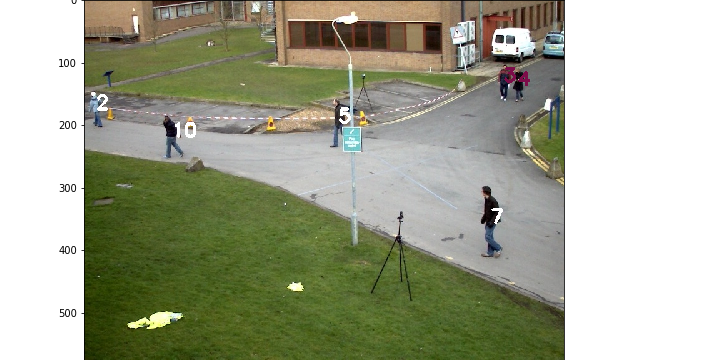

[]
0 1
207.80038498520642
[]
0 2
108.90362712049586
[]
0 3
216.00231480241132
[]
1 2
133.76471881628578
[]
1 3
422.26295125194207
[]
2 3
318.014150628553
Took  0.003967761993408203  seconds to get groups!
[]
[]
0 1
200.6315030098713
[]
0 2
108.90362712049586
[]
0 3
221.68671588527806
[]
1 2
127.7810627597063
[]
1 3
417.17142759302203
[]
2 3
318.014150628553
Took  0.0019903182983398438  seconds to get groups!
[]
[]
0 1
198.8617610301186
[]
0 2
108.90362712049586
[]
0 3
230.8679276123039
[]
1 2
125.0
[]
1 3
413.88524979757375
[]
2 3
318.014150628553
Took  0.0014884471893310547  seconds to get groups!
[]
[]
0 1
190.8219064992277
[]
0 2
108.90362712049586
[]
0 3
234.88720697390056
[]
1 2
120.8056290079233
[]
1 3
407.23580392691406
[]
2 3
318.014150628553
Took  0.0034444332122802734  seconds to get groups!
[]
[]
0 1
187.1095935541521
[]
0 2
108.90362712049586
[]
0 3
238.41560351621283
[]
0 4
257.6140524117425
[]
1 2
115.7410903698423
[]
1 3
403.39806643066595
[]
1 4
413.59158598791635
[]
2 

[]
0 1
158.24032355881985
[]
0 2
108.90362712049586
[]
0 3
216.00231480241132
[]
0 4
257.6140524117425
[]
1 2
72.80109889280519
[]
1 3
374.2098341839776
[]
1 4
380.54828865730036
[]
2 3
318.014150628553
[]
2 4
330.92597359530424
[]
3 4
30.0
Took  0.06001591682434082  seconds to get groups!
[<__main__.Group object at 0x0000027C0278E9B0>, <__main__.Group object at 0x0000027C13753C88>]
[]
0 1
158.24032355881985
[]
0 2
108.90362712049586
[]
0 3
216.00231480241132
[]
0 4
257.6140524117425
[]
1 2
72.80109889280519
[]
1 3
374.2098341839776
[]
1 4
380.54828865730036
[]
2 3
318.014150628553
[]
2 4
330.92597359530424
[]
3 4
27.892651361962706
Took  0.06398367881774902  seconds to get groups!
[<__main__.Group object at 0x0000027C028CD1D0>, <__main__.Group object at 0x0000027C00C1CAC8>]
[]
0 1
158.24032355881985
[]
0 2
108.90362712049586
[]
0 3
216.00231480241132
[]
0 4
257.6140524117425
[]
1 2
72.80109889280519
[]
1 3
374.2098341839776
[]
1 4
380.54828865730036
[]
2 3
318.014150628553
[]
2 4
330.

[]
0 1
158.24032355881985
[]
0 2
108.90362712049586
[]
0 3
216.00231480241132
[]
0 4
257.6140524117425
[]
0 5
322.7692674341843
[]
1 2
72.80109889280519
[]
1 3
374.2098341839776
[]
1 4
380.54828865730036
[]
1 5
382.6486639203122
[]
2 3
318.014150628553
[]
2 4
330.92597359530424
[]
2 5
354.17509793885847
[]
3 4
41.0
[]
3 5
166.33700730745397
[]
4 5
139.0898989862312
Took  0.17111921310424805  seconds to get groups!
[<__main__.Group object at 0x0000027C00C5BF60>, <__main__.Group object at 0x0000027C00BB3D30>]
[]
0 1
158.24032355881985
[]
0 2
108.90362712049586
[]
0 3
216.00231480241132
[]
0 4
257.6140524117425
[]
0 5
322.7692674341843
[]
1 2
72.80109889280519
[]
1 3
374.2098341839776
[]
1 4
380.54828865730036
[]
1 5
382.6486639203122
[]
2 3
318.014150628553
[]
2 4
330.92597359530424
[]
2 5
354.17509793885847
[]
3 4
42.190046219457976
[]
3 5
164.17368851311102
[]
4 5
139.0898989862312
Took  0.17905521392822266  seconds to get groups!
[<__main__.Group object at 0x0000027C0279EEB8>, <__main

[]
0 1
78.74642849044012
[]
0 2
86.68333173107735
[]
0 3
249.85195616604645
[]
0 4
287.5430402565849
[]
0 5
322.7692674341843
[]
1 2
46.95742752749558
[]
1 3
320.97507691408066
[]
1 4
357.1442285687954
[]
1 5
378.8456149937597
[]
2 3
283.3407842157567
[]
2 4
319.513692977312
[]
2 5
354.17509793885847
[]
3 4
39.20459156782532
[]
3 5
162.92636373527768
[]
4 5
139.0898989862312
Took  0.27825450897216797  seconds to get groups!
[<__main__.Group object at 0x0000027C14FFAF28>, <__main__.Group object at 0x0000027C028CD470>]
[]
0 1
78.43468620451031
[]
0 2
90.80198235721508
[]
0 3
255.7381473304286
[]
0 4
290.3532331488665
[]
0 5
322.7692674341843
[]
1 2
44.204072210600685
[]
1 3
316.8627463113958
[]
1 4
349.86425939212484
[]
1 5
378.8456149937597
[]
2 3
279.22929645723065
[]
2 4
312.23388669393336
[]
2 5
354.17509793885847
[]
3 4
36.345563690772494
[]
3 5
162.92636373527768
[]
4 5
139.0898989862312
Took  0.28764891624450684  seconds to get groups!
[<__main__.Group object at 0x0000027C1570FBA8

[]
0 1
111.5437134042076
[]
0 2
119.07980517283357
[]
0 3
183.17477992343814
[]
0 4
216.03703386225243
[]
0 5
322.7692674341843
[]
0 6
142.42541907960108
[]
1 2
35.35533905932738
[]
1 3
238.5036687348855
[]
1 4
266.5576860643865
[]
1 5
378.8456149937597
[]
1 6
187.40864441108366
[]
2 3
204.00490190189058
[]
2 4
232.44139046219803
[]
2 5
352.4826236851967
[]
2 6
213.80598681982693
[]
3 4
34.48187929913333
[]
3 5
162.92636373527768
[]
3 6
233.32380932943812
[]
4 5
139.0898989862312
[]
4 6
258.24213443975407
[]
5 6
350.7720057245162
Took  0.3368077278137207  seconds to get groups!
[<__main__.Group object at 0x0000027C02796E48>, <__main__.Group object at 0x0000027C02796F60>]
[]
0 1
111.5437134042076
[]
0 2
119.07980517283357
[]
0 3
183.17477992343814
[]
0 4
216.03703386225243
[]
0 5
322.7692674341843
[]
0 6
142.42541907960108
[]
1 2
28.42534080710379
[]
1 3
230.5666931714119
[]
1 4
263.65507770570247
[]
1 5
378.8456149937597
[]
1 6
189.01058171435798
[]
2 3
204.46271053666484
[]
2 4
238.09

1 5
335.2014319778482
[]
1 6
203.66639388961548
[]
2 3
136.79546776117988
[]
2 4
172.96531444194238
[]
2 5
315.9303720758737
[]
2 6
213.80598681982693
[]
3 4
38.47076812334269
[]
3 5
179.32372960654146
[]
3 6
255.16269319788896
[]
4 5
145.90750494748377
[]
4 6
281.81021982887705
[]
5 6
366.61696632861936
Took  0.37645983695983887  seconds to get groups!
[<__main__.Group object at 0x0000027C007AF908>, <__main__.Group object at 0x0000027C007AFDD8>]
[]
0 1
111.5437134042076
[]
0 2
119.07980517283357
[]
0 3
183.17477992343814
[]
0 4
216.03703386225243
[]
0 5
308.3180176376334
[]
0 6
170.20575783445165
[]
1 2
23.853720883753127
[]
1 3
140.73023839957068
[]
1 4
181.91481522954638
[]
1 5
321.6162309337015
[]
1 6
205.7692882818036
[]
2 3
122.78436382536663
[]
2 4
165.46903033498444
[]
2 5
303.4633421024688
[]
2 6
213.80598681982693
[]
3 4
44.181444068749045
[]
3 5
180.93645293306707
[]
3 6
258.24213443975407
[]
4 5
141.0319112825179
[]
4 6
285.1701246624548
[]
5 6
370.47132142717874
Took  0.36

4 5
117.17508267545622
[]
4 6
309.5109044928789
[]
5 6
396.6787113017284
Took  0.4091951847076416  seconds to get groups!
[<__main__.Group object at 0x0000027C026FB0B8>, <__main__.Group object at 0x0000027C026FB630>]
[]
0 1
111.5437134042076
[]
0 2
116.55899793666725
[]
0 3
183.17477992343814
[]
0 4
216.03703386225243
[]
0 5
308.3180176376334
[]
0 6
219.40145851839728
[]
1 2
38.40000000000002
[]
1 3
89.02246907382428
[]
1 4
110.64357188738983
[]
1 5
215.13948963405113
[]
1 6
229.0087334579186
[]
2 3
125.15989773086265
[]
2 4
145.49914089093448
[]
2 5
227.1299187689724
[]
2 6
228.07893370497854
[]
3 4
40.049968789001575
[]
3 5
158.14234094637652
[]
3 6
286.29530209208815
[]
4 5
120.55289295574785
[]
4 6
314.5059617876901
[]
5 6
401.99129343805447
Took  0.4122021198272705  seconds to get groups!
[<__main__.Group object at 0x0000027C02788390>, <__main__.Group object at 0x0000027C02788C18>]
[]
0 1
111.5437134042076
[]
0 2
116.55899793666725
[]
0 3
183.17477992343814
[]
0 4
216.037033862252

4 5
94.86832980505137
[]
4 6
331.30801378777426
[]
4 7
191.75505208468434
[]
5 6
419.980951949014
[]
5 7
139.38794782907166
[]
6 7
586.9241859047896
Took  0.45529913902282715  seconds to get groups!
[<__main__.Group object at 0x0000027C155BDCC0>, <__main__.Group object at 0x0000027C15BE4F60>]
[]
0 1
111.5437134042076
[]
0 2
109.04127658827184
[]
0 3
183.17477992343814
[]
0 4
216.03703386225243
[]
0 5
308.3180176376334
[]
0 6
289.394194827747
[]
0 7
255.38402455909414
[]
1 2
38.41874542459709
[]
1 3
123.22743201089601
[]
1 4
147.6787053031005
[]
1 5
211.43556938225885
[]
1 6
242.36542657730703
[]
1 7
364.1455752854894
[]
2 3
159.17600321656528
[]
2 4
182.56231812726304
[]
2 5
245.47301277329856
[]
2 6
236.6981199756348
[]
2 7
363.45563690772497
[]
3 4
34.48187929913333
[]
3 5
125.14391715141412
[]
3 6
303.8173793580611
[]
3 7
211.85136298829894
[]
4 5
92.5418824100742
[]
4 6
332.776201072132
[]
4 7
187.52333188166213
[]
5 6
421.5839180993506
[]
5 7
139.38794782907166
[]
6 7
586.92418590

[]
0 2
225.93804460515275
[]
0 3
187.0106948813356
[]
0 4
214.03737991294884
[]
0 5
303.2375306587231
[]
0 6
402.3779318004406
[]
0 7
133.09395177843356
[]
0 8
153.44380078712857
[]
2 3
213.45959805077868
[]
2 4
237.24459951703852
[]
2 5
304.2449670906653
[]
2 6
268.337474088134
[]
2 7
354.6857764275303
[]
2 8
371.9274122728789
[]
3 4
27.294688127912362
[]
3 5
117.5457357797381
[]
3 6
342.1637035104688
[]
3 7
188.66107176627614
[]
3 8
219.24415613648634
[]
4 5
90.2551937563706
[]
4 6
369.04877726392755
[]
4 7
166.29191201017565
[]
4 8
198.97989848223364
[]
5 6
458.0
[]
5 7
128.86038956948718
[]
5 8
166.5172663719892
[]
6 7
586.9241859047896
[]
6 8
654.2973330222278
[]
7 8
143.26548781894402
Took  0.36799001693725586  seconds to get groups!
[]
0 2
230.32585612562042
[]
0 3
187.17104476921637
[]
0 4
217.02073633641555
[]
0 5
303.19960422137757
[]
0 6
405.6106507477337
[]
0 7
127.09838708654017
[]
0 8
146.03081866510234
[]
2 3
217.57297626313797
[]
2 4
239.43683927081898
[]
2 5
305.439028

5 7
126.28935030318273
[]
5 8
162.24980739587951
[]
5 9
269.31951284673005
[]
6 7
586.9241859047896
[]
6 8
654.2973330222278
[]
6 9
348.209706929603
[]
7 8
171.09354166653983
[]
7 9
115.24755962709145
[]
8 9
280.8131051072937
Took  0.40421032905578613  seconds to get groups!
[<__main__.Group object at 0x0000027C1501C240>, <__main__.Group object at 0x0000027C1501C2B0>, <__main__.Group object at 0x0000027C1501C198>]
[]
0 2
290.4496514027862
[]
0 3
171.81385275931623
[]
0 4
196.6214637317096
[]
0 5
274.7289573379552
[]
0 6
485.74067155221826
[]
0 7
65.11528238439882
[]
0 8
87.80091115700337
[]
0 9
245.78242410717655
[]
2 3
240.65119987234635
[]
2 4
259.4802497301095
[]
2 5
325.4980798714487
[]
2 6
293.2319900692965
[]
2 7
351.7627041060493
[]
2 8
366.61287484211465
[]
2 9
55.46169849544819
[]
3 4
26.30589287593181
[]
3 5
107.20074626605917
[]
3 6
385.77843381920667
[]
3 7
176.08236708995025
[]
3 8
208.19462048765814
[]
3 9
185.9946235782099
[]
4 5
80.89499366462674
[]
4 6
409.923163531899

[]
0 2
287.2107240337658
[]
0 3
154.50566332662373
[]
0 4
175.5135322418189
[]
0 5
246.52180430947686
[]
0 6
501.2833530050644
[]
0 7
65.11528238439882
[]
0 8
87.80091115700337
[]
2 3
259.3067681338071
[]
2 4
279.1200458584084
[]
2 5
330.0802932621092
[]
2 6
315.9572755927611
[]
2 7
348.9670471548854
[]
2 8
363.2079294288603
[]
3 4
23.08679276123039
[]
3 5
98.41239759298622
[]
3 6
429.7731959999367
[]
3 7
168.24089871371942
[]
3 8
201.45719148245863
[]
4 5
75.32595834106593
[]
4 6
452.76925690687085
[]
4 7
153.39491516996253
[]
4 8
188.04254837669055
[]
5 6
527.8882457490411
[]
5 7
182.6608879864543
[]
5 8
162.24980739587951
[]
6 7
586.9241859047896
[]
6 8
654.2973330222278
[]
7 8
244.36448187083164
Took  0.4702463150024414  seconds to get groups!
[<__main__.Group object at 0x0000027C15BE4630>, <__main__.Group object at 0x0000027C15686518>]
[]
0 2
285.8898389240163
[]
0 3
155.07740002979156
[]
0 4
173.61163555476344
[]
0 5
246.9109151090733
[]
0 6
503.1073444107132
[]
0 7
65.1152823843

4 7
144.00347218036097
[]
4 10
256.8462575160479
[]
5 6
579.5446488407947
[]
5 7
198.2952344359289
[]
5 10
272.3692346796899
[]
6 7
586.9241859047896
[]
6 10
401.40004982560725
[]
7 10
43.41658669218482
Took  0.4969911575317383  seconds to get groups!
[<__main__.Group object at 0x0000027C10FA6940>, <__main__.Group object at 0x0000027C10FA6630>, <__main__.Group object at 0x0000027C10FA64E0>]
[]
0 2
281.99645387841315
[]
0 3
148.22280526288793
[]
0 4
155.2063143045411
[]
0 5
218.04815981796315
[]
0 6
525.9248995816798
[]
0 7
65.11528238439882
[]
0 10
138.51353724455961
[]
2 3
269.4290259047826
[]
2 4
293.027302482209
[]
2 5
322.6019218789622
[]
2 6
343.4020966738555
[]
2 7
344.223764432382
[]
2 10
61.71709649683789
[]
3 4
28.160255680657446
[]
3 5
95.1892851112981
[]
3 6
491.20260585628006
[]
3 7
164.51443705644803
[]
3 10
239.30106560565082
[]
4 5
71.06335201775947
[]
4 6
515.3882032022076
[]
4 7
144.00347218036097
[]
4 10
256.8462575160479
[]
5 6
586.2874721499684
[]
5 7
198.2952344359

[]
0 2
281.99645387841315
[]
0 3
148.22280526288793
[]
0 4
141.718029904455
[]
0 5
188.06381895516213
[]
0 6
542.8489661038326
[]
0 7
61.801216009322566
[]
0 10
119.41942890501528
[]
0 11
211.28653530218153
[]
0 12
501.32823578968697
[]
2 3
286.8815086407627
[]
2 4
308.65028754238995
[]
2 5
349.0444097819073
[]
2 6
296.97811367169805
[]
2 7
315.5724956329369
[]
2 10
132.9661611087573
[]
2 11
17.24082810789997
[]
2 12
289.8309852310481
[]
3 4
26.30589287593181
[]
3 5
86.37129152675674
[]
3 6
547.6130020370225
[]
3 7
136.61625086350452
[]
3 10
239.30106560565082
[]
3 11
371.4458237751503
[]
3 12
641.0280805081786
[]
4 5
61.18823416311342
[]
4 6
573.846669416143
[]
4 7
155.68236894394946
[]
4 10
256.8462575160479
[]
4 11
393.82483415853807
[]
4 12
665.0270671183241
[]
5 6
632.9138961975791
[]
5 7
215.60380330597138
[]
5 10
263.40273347101015
[]
5 11
348.7491935474547
[]
5 12
621.3219777216963
[]
6 7
569.590203567442
[]
6 10
429.9441824237188
[]
6 11
306.88271375233893
[]
6 12
14.035668847

[]
0 2
281.99645387841315
[]
0 3
148.22280526288793
[]
0 4
156.28499608087785
[]
0 5
164.6572197020222
[]
0 6
564.3066542226842
[]
0 7
61.801216009322566
[]
0 10
119.41942890501528
[]
2 3
339.0
[]
2 4
358.70879554312575
[]
2 5
372.2646907779463
[]
2 6
293.2643858363985
[]
2 7
245.34465553584002
[]
2 10
166.02710622064097
[]
3 4
21.02379604162864
[]
3 5
36.05551275463989
[]
3 6
589.8686294421835
[]
3 7
159.38946012832844
[]
3 10
267.4341040331244
[]
4 5
19.79898987322333
[]
4 6
609.8934333143783
[]
4 7
176.6635219845908
[]
4 10
284.70335438838794
[]
5 6
624.0392615853589
[]
5 7
188.16216410320115
[]
5 10
263.40273347101015
[]
6 7
523.0468430265114
[]
6 10
430.4195627524381
[]
7 10
50.80354318352215
Took  0.5505359172821045  seconds to get groups!
[<__main__.Group object at 0x0000027C3CEB9828>, <__main__.Group object at 0x0000027C3CEB9400>]
[]
0 2
281.99645387841315
[]
0 3
148.22280526288793
[]
0 4
159.2262541165872
[]
0 5
160.96272860510285
[]
0 6
570.2920304545734
[]
0 7
61.80121600932

[]
0 2
336.4654514210932
[]
0 3
169.7056274847714
[]
0 4
183.35757415498276
[]
0 5
135.9779393872403
[]
0 7
130.00384609695206
[]
0 10
186.45374761586316
[]
2 3
450.2543725495623
[]
2 4
471.78490861832364
[]
2 5
399.7211528053025
[]
2 7
283.9242856819402
[]
2 10
158.59697348940804
[]
3 4
25.079872407968907
[]
3 5
53.31041174104736
[]
3 7
188.76705220985997
[]
3 10
350.7035785389137
[]
4 5
73.00684899377592
[]
4 7
206.8260138377182
[]
4 10
369.4455304913026
[]
5 7
185.80904176062046
[]
5 10
263.74609001841145
[]
7 10
136.36715146984628
Took  0.4335033893585205  seconds to get groups!
[]
0 2
346.2210276687423
[]
0 3
173.24260445975753
[]
0 4
186.47251808242416
[]
0 5
136.12431887315086
[]
0 7
121.01652779682617
[]
0 10
198.84164553734712
[]
2 3
463.38968482261237
[]
2 4
485.73346600785084
[]
2 5
403.40178482500545
[]
2 7
293.8588096348313
[]
2 10
148.94629904767692
[]
3 4
25.079872407968907
[]
3 5
64.8459713474939
[]
3 7
192.35384061671346
[]
3 10
364.16617086159994
[]
4 5
84.20213774008

[]
0 2
411.0596063833079
[]
0 3
197.6486782146544
[]
0 4
212.40762698170704
[]
0 5
157.2768260107
[]
0 7
94.04786015641186
[]
0 10
268.70057685088807
[]
2 3
553.2639514734356
[]
2 4
575.7612352355792
[]
2 5
406.01108359255414
[]
2 7
359.3563690822802
[]
2 10
143.58969322343438
[]
3 4
25.079872407968907
[]
3 5
152.42703172337903
[]
3 7
218.69156362329116
[]
3 10
428.2207374707582
[]
4 5
173.17043627594174
[]
4 7
237.40261161158273
[]
4 10
447.93079822669034
[]
5 7
195.0179478919825
[]
5 10
272.90474528670256
[]
7 10
222.14409737825582
Took  0.47712039947509766  seconds to get groups!
[]
0 2
419.2970307550484
[]
0 3
200.66140635408692
[]
0 4
214.61127649776466
[]
0 5
159.3026186988912
[]
0 7
91.98369420718001
[]
0 10
276.90431560378397
[]
2 3
565.0424762794387
[]
2 4
585.6551886562604
[]
2 5
407.0196555450363
[]
2 7
370.8072275455267
[]
2 10
143.58969322343438
[]
3 4
25.079872407968907
[]
3 5
164.43843832875572
[]
3 7
221.41589825484527
[]
3 10
435.61106505689224
[]
4 5
183.3930205869351

3 10
524.9276140574051
[]
4 5
285.2402496142506
[]
4 7
253.64739304790814
[]
4 10
549.7681329433345
[]
5 7
200.7211996775627
[]
5 10
264.5996976566678
[]
7 10
323.12536266904215
Took  0.34471893310546875  seconds to get groups!
[]
2 3
650.4898154467909
[]
2 4
674.1876593352922
[]
2 5
387.3732050619919
[]
2 7
458.68071683906663
[]
2 10
147.07821048680188
[]
3 4
25.079872407968907
[]
3 5
269.0074348414928
[]
3 7
232.43278598338918
[]
3 10
532.9840522942502
[]
4 5
291.62475889402805
[]
4 7
251.0019920239678
[]
4 10
556.0791310596002
[]
5 7
200.7211996775627
[]
5 10
265.18107021429716
[]
7 10
330.9637442379452
Took  0.37197184562683105  seconds to get groups!
[]
2 3
653.4164062831603
[]
2 4
676.0687834828643
[]
2 5
388.5678833871889
[]
2 7
461.8073191277938
[]
2 10
157.30543537970962
[]
3 4
25.079872407968907
[]
3 5
271.64682954159434
[]
3 7
232.24555969921147
[]
3 10
538.0799197145346
[]
4 5
293.00170647967224
[]
4 7
249.64775184247102
[]
4 10
560.0357131469385
[]
5 7
200.7211996775627
[]

In [ ]:
height, width, channels = cv2.imread(images[0]).shape
detector = YoloDetector(width, height)
cur_people = []
cur_person_id = 0

fourcc = cv2.VideoWriter_fourcc(*'XVID')
framerate = 7
video_out = cv2.VideoWriter("tracking-output.avi", fourcc, framerate, (width,height))

OVERLAP_THRESHOLD_RATIO = 0.4

DETECT_WINDOW = 'Detection'
DETECT_COLOR = (255,0,0) # blue
UNTRACK_COLOR = (255,0,191) # purple
TRACK_COLOR = (0,0,255) # red

FLOW_WINDOW = 'Flow'
MASK_WINDOW = 'Mask'

INTERACTIVE_CONTROL = True
ESC_KEY = 27
PAUSE_KEY = ord('p')
NEXT_KEY = ord('n')
KEY_LIST = [ESC_KEY, PAUSE_KEY, NEXT_KEY]

STD_DEV = 10 # px
CONST_hc = 0.3
CONST_std_m = STD_DEV
CONST_alpha_occlus = 0.6
EUCLIDEAN_THRES = 100-25 # px, for Hungarian

FRAME_START = 12 #460 #390 #128
DRAW_PARTICLES = False

# https://stackoverflow.com/questions/15933741/how-do-i-catch-a-numpy-warning-like-its-an-exception-not-just-for-testing
np.seterr(all='raise') 
is_interactive = INTERACTIVE_CONTROL

# Setup plot
plt.close('all')
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout = True
fig.subplotpars.left=0
fig.subplotpars.top=1
fig.subplotpars.bottom=0
fig.subplotpars.wspace=0.1
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(122)
# ax3 = fig.add_subplot(133)
plt.ion()
fig.show()
fig.canvas.draw()

# initialize YOLO detector
# detector = YoloDetector()
prev_img = cv2.imread(images[0])

# Store previous 3 groups
num_prev_frames = 3
prev_groups = [None] * num_prev_frames

gID_count = 0

for n, cur_img in enumerate(images[FRAME_START:]):
    ax1.clear()
    cur_img = cv2.imread(cur_img)

    ###############################
    # [DETECTION & BACKGROUND SUBTRACTION]
    # setup
    cur_img_gray = cv2.cvtColor(cur_img,cv2.COLOR_BGR2GRAY)
    bw_mask = bg_subtract(cur_img)
    
    # 1. apply detector on new frame
    detected_boxes = detector.get_detection(cur_img)
    
    ###############################
    # [TRACKING]
    # 2. match detections to existing Person
    if n > 0:
        __, __, flow_rgb, flow_res = get_optical_flow(prev_img_gray, cur_img_gray)
        # associate trackers (existing Person) to detected bboxes by distance
        p_idx_list, d_idx_list, unp_idx_list, und_idx_list = hungarian_algorithm(cur_people, detected_boxes, EUCLIDEAN_THRES)
        
        # paired (trackers, detected)
        for index_pair in range(len(p_idx_list)):
            # update tracker to use detector's coords
            p = cur_people[ p_idx_list[index_pair] ]
            cur_x, cur_y, cur_w, cur_h = detected_boxes[ d_idx_list[index_pair] ]
            # tracker prediction (results unused...)
            cur_vx, cur_vy, cur_std = get_velocity_stats(p, flow_res, bw_mask)
            p.predict_tracker(cur_vx, cur_vy, STD_DEV, cur_img, n)
            # tracker update
            detected_bbox = (cur_x, cur_y, cur_w, cur_h, n, False)
            p.update_tracker(detected_bbox, cur_img, bw_mask, CONST_hc, None, None, False)
            # NOTE: our detector is likely more accurate than our tracker; atm I don't know
            # how to directly associate the detected bbox to the tracker with the
            # color histogram approach?
            
        # unpaired trackers
        for unpaired_index in unp_idx_list:  # (no index pairing required)
            # predict
            p = cur_people[unpaired_index]
            cur_vx, cur_vy, cur_std = get_velocity_stats(p, flow_res, bw_mask)
            predicted_bbox = p.predict_tracker(cur_vx, cur_vy, STD_DEV, cur_img, n)
            predicted_bbox = tuple(list(predicted_bbox) + [n, True])
            # update
            p.update_tracker(predicted_bbox, cur_img, bw_mask, CONST_hc, 
                             CONST_std_m, CONST_alpha_occlus, True)
            
    else:
        # unpaired detected bboxes (see Step 3.)
        und_idx_list = list(range(len(detected_boxes))) # all undetected
        p_idx_list = [] # to aid plotting
        d_idx_list = []
        unp_idx_list = []

    # 3. create new Person for each unpaired bbox
    unpaired_start_index = len(cur_people)
    for unpaired_index in und_idx_list:  # (no index pairing required)
        cur_x, cur_y, cur_w, cur_h = detected_boxes[ unpaired_index ]
        p = Person( (cur_x,cur_y,cur_w,cur_h,n,False), width,height,100, 
                   cur_person_id, cur_img, bw_mask, CONST_hc)
        cur_people.append(p)
        cur_person_id += 1
    
    # NOTE: we remove stale trackers after plotting results, for coding convenience
    
    ###############################
    # [PLOT TRACKING-ONLY RESULTS]
    cur_img_display = copy.copy(cur_img)
    post_x, post_y, post_w, post_h = Person.INNER_BORDER_RECT
    cur_img_display = cv2.rectangle(cur_img_display, (post_x, post_y), 
                                    (post_x+post_w, post_y+post_h), (0,0,0), 1)
    cur_img_display = cv2.rectangle(cur_img_display, (Person.BORDER_PX, Person.BORDER_PX), 
                                    (width-Person.BORDER_PX, height-Person.BORDER_PX), (0,0,0), 1)
    cv2.putText(cur_img_display, f'Fm {FRAME_START+n}', (0,20), FONT, 0.75, (255,0,0),2)  # frame id
    
    # paired (trackers, detected)
    for index_pair in range(len(p_idx_list)):
        p = cur_people[ p_idx_list[index_pair] ]
        cur_bbox = p.get_latest_ords()[:4]
        #cur_bbox = detected_boxes[ d_idx_list[index_pair] ]
        cur_img_display = draw_rectangle(cur_img_display, cur_bbox, str(p.person_id), FONT, DETECT_COLOR)
    
    # unpaired trackers
    for unpaired_index in unp_idx_list:
        p = cur_people[unpaired_index]
        cur_bbox = p.get_latest_ords()[:4]
        cur_img_display = draw_rectangle(cur_img_display, cur_bbox, str(p.person_id), FONT, TRACK_COLOR)
    
    # unpaired detected bboxes
    for unpaired_index in range(unpaired_start_index, len(cur_people)):
        p = cur_people[unpaired_index]
        cur_bbox = p.get_latest_ords()[:4]
        cur_img_display = draw_rectangle(cur_img_display, cur_bbox, str(p.person_id), FONT, UNTRACK_COLOR)
        
    # tracker predictions, particles
    for p in cur_people:
        if p.last_prediction == None: # i.e ignore new Person
            continue
        cur_img_display = p.draw(cur_img_display, TRACK_COLOR, 
                                 enable_particles=DRAW_PARTICLES, draw_last_predicted=True)
    
    ###############################
    # [TRACKING CLEAN-UP]
    # remove stale trackers
    p_index = 0
    while p_index < len(cur_people):
        p = cur_people[p_index]
        if p.is_stale_tracker(cur_img):
            del cur_people[p_index]
            continue
        p_index += 1
    
#     ###############################
#     # [ENABLE WINDOWS]
#     cv2.imshow(DETECT_WINDOW, cur_img_display)
#     if n > 0:
#         flow_arrow = draw_flow(cur_img_gray, flow_res, step=8)
#         cv2.imshow(FLOW_WINDOW, flow_arrow)
#     else:
#         cv2.imshow(FLOW_WINDOW, cur_img_display)
#     cv2.imshow(MASK_WINDOW, cv2.bitwise_and(cur_img, cur_img, mask=bw_mask))

    # cur_people contains bbox history for each unique person, as well as their ID
    centroids = []
    
#     for p in cur_people:
#         centroids.append(centroid(p.get_latest_ords()[:4]))
#     distance_mat = get_distance_matrix(centroids)
#     distance_threshold = 70
#     vel_threshold = 6
#     groups = get_groups(distance_mat, cur_people, distance_threshold, vel_threshold)
#     groups = []
    t0 = time.time()
    groups = get_groups(cur_people)
    t1 = time.time()
    print("Took ", t1-t0, " seconds to get groups!")
    print(groups)
    
    # CHANGE THIS
    gID = -1
    for k in range(len(groups)):
        gID, color = get_group_id(groups[k], prev_groups)#, distance_threshold, vel_threshold)
        if gID == -1:
            groups[k].gID = gID_count
            gID_count = gID_count + 1
        else:
            groups[k].gID = gID
            groups[k].color = color
            
#     print(group_ids)
    
    # TODO: add velocity magnitude and direction into cost matrix (right now it is just distance matrix)
    # weight these individually so there is greater control to fine-tune the algorithm
    
    # TODO: Store previous n groups
    # associate current groups with previous groups to maintain number of pedestrians and ID of group
    # Then can work on group dynamics
#     for l in range(len(prev_groups)):
#         for m in range(len(prev_groups[l])):
            
    
    # NOTE IF VELOCITY IS TOO HIGH JUST THROW IT OUT (PF JUMPS AROUND UNDER OCCLUSION)
    # NOTE REMOVE COLOUR IMPLEMENTATION (WILL CRASH AFTER 7 UNIQUE GROUPS CREATED BECAUSE LIST IS ONLY 7/8 COLOURS LONG)
    
    # Print centroid ID (for current frame - changes each frame since no tracking is implemented) in white
    for p in cur_people:
#         print(centroids[c][0])
        org = centroid(p.get_latest_ords()[:4])
        cv2.putText(cur_img, str(p.person_id), org, fontFace=cv2.FONT_HERSHEY_SIMPLEX, color=(255,255,255), fontScale=1, thickness=3)
    
    # Color coordinate groups
    for k in range(len(groups)):
#         col = (randint(0,255),randint(0,255),randint(0,255))
        for l in range(len(groups[k].people)):
            org = centroid(groups[k].people[l].get_latest_ords()[:4])
            cv2.putText(cur_img, str(groups[k].people[l].person_id), org, fontFace=cv2.FONT_HERSHEY_SIMPLEX, color=groups[k].color, fontScale=1, thickness=3)
        
    ###############################
    # [BOOK-KEEPING FOR NEXT ITERATION]
    # setup for next iteration
    prev_img_gray = cur_img_gray
    prev_groups[n%num_prev_frames] = groups
    
    cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
#     img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    ax1.imshow(cur_img)
#     title = str('Num rects = ' + str(num_rects))
#     ax2.imshow(img2)
#     plt.title(title)
#     ax3.imshow(morphed,cmap='gray')
#     title = str('Frame = ' + str(n))
#     plt.title(title)
#     plt.pause(.1)
    fig.canvas.draw()
    

In [335]:
import pickle, io

In [395]:
with open("benchmark_trajectories.pkl", 'rb') as f:
    traj_list = pickle.load(f, encoding="bytes")[:2]
    print(len(traj_list))
    traj_A = traj_list[0][:2]
    traj_B = traj_list[1]
    print(traj_A.shape)
    print("B", traj_B.shape)
    dist = tdist.sspd(traj_A, traj_B)
    print(dist)
    pdist = tdist.pdist(traj_list, metric="sspd")
    print(pdist)

    # Distance between two list of trajectories

    cdist = tdist.cdist(traj_list, traj_list, metric="sspd")
    print(cdist)

2
(2, 2)
B (10, 2)
0.008881904557179132
[0.0048497]
[[0.        0.0048497]
 [0.0048497 0.       ]]


UnicodeDecodeError: 'ascii' codec can't decode byte 0x8e in position 1: ordinal not in range(128)